<a href="https://colab.research.google.com/github/KARENCMP82/Python/blob/main/1_METRICAS_DISTANCIAS_19MAR25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Nuclio Digital School - Máster en Data Science**

# Unsupervised Learning: Similitud y distancias

# *Profesora: Raquel Revilla*



<a id = "objetivos"></a>
# Objetivos del Notebook
[Volver al índice](#table_of_contents)

El presente notebook va a introducir al alumno a los conceptos básicos de **Aprendizaje No Supervisado (UL)**.

***¿Por qué decimos no supervisado?***

Tal y como su nombre indica, en el **Aprendizaje No Supervisado** tenemos un conjunto de datos de entrenamiento sin el correspondiente valor del target. <u>**Tenemos la X pero no la Y.**</u> Al principio podría parecer que si no tenemos el target de entrenamiento el dataset carece de valor, pero esto no es así.

Entre los principales problemas que buscan resolver los algoritmos de **Aprendizaje No Supervisado** se encuentran:

***¿Qué entendéis por clustering?***

1. **Clusterización/Segmentación de los datos**: se buscan grupos de <u>**ejemplos similares**</u> entre si y diferentes al resto de grupos. Por ejemplo: tenemos un dataset de clientes y queremos ver que grupos existen en función de determinados patrones que están ocultos en los datos. Ejecutando nuestro algoritmo de segmentación podríamos obtener las siguientes etiquetas: clientes digitales, clientes eco, clientes que compran exclusivamente en tiendas físicas, etc. Como es lógico, los clientes del grupo de "digitales" son muy parecidos entre sí y muy diferentes a los clientes "físicos".

***¿Qué es un recomendador?***

2. **Collaborative Filtering (Recommenders)**: con estos algoritmos queremos determinar <u>**la similitud**</u> entre ejemplos con el objetivo de ponderar alguna métrica para realizar recomendaciones. Se trata de ofrecer a clientes similares productos que vayan a gustar. Por ejemplo: tenemos un dataset de reviews de péliculas (n clientes que han hecho reviews a x péliculas). Ejecutando nuestro algoritmo de recomendación obtendriamos un score de similitud para cada cliente contra el resto de clientes. Sabríamos que un cliente se parece a otro porque han puesto notas similares a las mismas péliculas y con esta información podríamos construir una oferta personalizada de nuevas péliculas.


3. **Reducción de la dimensionalidad**: busca pasar de un espacio de **"m"** dimensiones a otro espacio de **"n"** dimensiones de tal manera que n << m. La utilidad de reducir la dimensionalidad de un dataset es para conseguir que sea mucho más manejable. Un dataset "pequeño" es más fácil de analizar, visualizar etc. Por este motivo, la reducción de la dimensionalidad suele ser un paso concreto dentro de un proyecto de Machine Learning (no un fin en si mismo).

![UL_INTRO](https://drive.google.com/uc?export=view&id=1CrALL3vdJxpY-MOWqLc-je92XjIJcyLj)

Un concepto recurrente que aparece en los puntos anteriores es **la idea de similitud.** Para agrupar a clientes similares (clústerización) o bien hacer recomendaciones basadas en gustos similares (collaborative filtering), **necesito poder calcular una métrica que me permita comparar a los clientes entre si de una manera objetiva.**

En este notebook veremos algunas de las formas más comunes para hacerlo.

Al final de la sesión, el alumno se debe sentir cómodo con los siguientes conceptos:

1. Comprender que es la distancia Euclídea y la de Manhattan (**CORE IDEA**).

2. **Aplicación de estas dos distancias a un dataset**, para encontrar en base a nuestras variables a los clientes más parecidos (los que más cerca están en nuestro espacio dimensional).

3. Ver en la práctica que problemas pueden surgir si tenemos diferentes escalas en nuestro dataset (**CORE IDEA**).

4. Aplicar la idea de distancias para ver algoritmos de "aprendizaje por instancias".

---

Las ideas más importantes están marcadas con **CORE IDEA** y recomendamos a los alumnos que centren sus esfuerzos en estos apartados.

Al final del notebook, hay un sección de referencias y lecturas recomendables para que el alumno pueda seguir profundizando en estos conceptos.

---

<a id = "table_of_contents"></a>

# Índice

[Importación de las Principales Librerías](#import_modules)

[GLOBAL_VARIABLES](#global_variables)

[Funciones Auxiliares](#helpers)

[Generación de un dataset](#dataset)

[Cálculo de distancias](#distances)

---> [Distancia Euclídea Sin Estandarización](#euclidea_bad)

---> [Distancia de Manhattan Sin Estandarización](#manhattan_bad)

---> [Distancia Euclídea Con Estandarización](#euclidea_bien)

---> [Distancia de Manhattan Con Estandarización](#manhattan_bien)

[Otras formas de procesar los datos](#transformers)

[Comparación de los Transformers](#scaler_comparison)

[Aprendizaje Basado en Instancias](#knn)

[Conclusión](#conclusión)

[Referencias y lecturas recomendables](#referencias)

<a id = "import_modules"></a>
# Importación de las Principales Librerías
[Volver al índice](#table_of_contents)

En esta sección hacemos los imports de las principales librerías.

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import set_config
set_config(transform_output = "pandas")
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from sklearn.datasets import load_diabetes
from sklearn.impute import KNNImputer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id = "global_variables"></a>
# GLOBAL_VARIABLES
[Volver al índice](#table_of_contents)

Definimos las GLOBAL_VARIABLES que afectarán a nuestro notebook.

In [3]:
COLOR = "#2a9d8f"
COLOR_MAX = "#D8E4FF"

<a id = "helpers"></a>
# Funciones Auxiliares
[Volver al índice](#table_of_contents)

Definimos las funciones que vamos a usar en el resto del notebook.

Propósito: Genera una visualización de la distancia euclídea entre dos puntos en un espacio bidimensional (2D).

Elementos visuales:

Ejes cartesianos con límites de -10 a 10.

Líneas discontinuas para representar los ejes X e Y.

Un triángulo rectángulo que ilustra el cálculo de la distancia euclídea (hipotenusa) a partir de las diferencias en las coordenadas X e Y (catetos).

Puntos que representan las coordenadas (x1, y1) y (x2, y2).

Anotaciones que explican los componentes del cálculo de la distancia (x2 - x1, y2 - y1, d).

Título: "Euclidean Distance Between 2 Vectors in a 2D Space"

En resumen: La función crea un gráfico que explica visualmente cómo se calcula la distancia euclídea utilizando el teorema de Pitágoras en un plano 2D.

La **distancia euclídea** es la distancia en línea recta entre dos puntos en un espacio euclídeo (que puede ser de 2, 3 o más dimensiones). Es la forma más común e intuitiva de medir la distancia "ordinaria" entre dos puntos.

In [4]:
def plot_euclidean_distance():
    '''
    Makes a simple plot of an Euclidean distances in a 2D space.
    Returns nothing. Renders the plot on the function call.
    '''
    # instanciamos la figure y el axes
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)

    # creamos una espacio cartesiona
    lims = (-10, 10)
    alpha = 0.5
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    # pintamos lineas horizontales y verticales
    ax.vlines(0, -10, 10, linestyles = "--", alpha = alpha)
    ax.hlines(0, -10, 10, linestyles = "--", alpha = alpha)

    # pintamos los dos catetos y la hipotenusa
    ax.plot([0, 5], [0, 5], alpha = alpha, color = "red", lw = 2) # hipotenusa
    ax.text(2, 3.5, s = "d", fontsize = 8, color = "red")

    ax.plot([0, 5], [0, 0], alpha = alpha, color = "blue", lw = 2) # cateto azul
    ax.text(1.5, -1, s = "x2 - x1", fontsize = 8, color = "blue")

    ax.plot([5, 5], [5, 0], alpha = alpha, color = "green", lw = 2) # cateto verde

    # origen
    ax.scatter([0, 0], [0, 0], alpha = alpha, color = "black", lw = 2)
    ax.text(-1, -1, s = "(x1, y1)", fontsize = 8, color = "black")

    # punto 2
    ax.scatter([0, 5], [0, 5], alpha = alpha, color = "black", lw = 2)
    ax.text(5.5, 5.5, s = "(x2, y2)", fontsize = 8, color = "black")

    # punto en el eje x
    ax.scatter([5, 0], [0, 0], alpha = alpha, color = "black", lw = 2)

    # cálculo
    ax.text(1.5, -1, s = "x2 - x1", fontsize = 8, color = "blue")
    ax.text(5.5, 2, s = "y2 - y1", fontsize = 8, color = "green")

    # creamos las listas para los ejes (-10 hasta 10)
    x_ticks = [x for x in range(-10, 11)]
    y_ticks = [y for y in range(-10, 11)]

    # enumeramos los ejes desde -10 hasta 10
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)

    # ponemos el título
    fig.suptitle("Euclidean Distance Between 2 Vectors in a 2D Space");

In [17]:
def calculate_distances(X, index, distance_func):
    '''
    Calcula las distancias entre vectores utilizando la función especificada que se le pasa.
    Devuelve un DataFrame de pandas.
    '''
    distances = distance_func(X = X)  # Calcula la matriz de distancias utilizando la función 'distance_func' (ej: euclidean_distances, manhattan_distances) aplicada al DataFrame 'X'. El resultado es una matriz NumPy con las distancias entre todos los pares de filas en 'X'.
    distances = pd.DataFrame(distances, index = index, columns = index)  # Convierte la matriz de distancias en un DataFrame de pandas, utilizando la lista 'index' para nombrar tanto las filas como las columnas.
    distances = round(distances, 1)  # Redondea todos los valores del DataFrame a 1 decimal.
    distances.replace(to_replace = 0, value = np.nan, inplace = True)  # Reemplaza los valores de distancia que son exactamente 0 con NaN (Not a Number).  'inplace=True' modifica el DataFrame directamente.

    return distances  # Devuelve el DataFrame de pandas que contiene las distancias calculadas.

In [6]:
def format_cell_based_on_target_value(value, target_value, highlight = 'background-color: yellow'):
    '''
    Formats a cell based on a target_value.
    Returns a background color or pass.
    '''
    if value == None:
        pass
    elif value == target_value:
        return highlight
    else:
        return ""

<a id = "dataset"></a>
# Generación de un dataset
[Volver al índice](#table_of_contents)

Vamos a generar un dataset dummy con el que vamos a trabajar.

In [7]:
data = {
    "1. Edad":[18, 30, 21, 25, 33, 33],
    "2. Peso":[90, 70, 77, 60, 80, 80],
    "3. Altura":[180, 175, 170, 183, 185, 185],
    "4. Nómina":[2000, 1500, 3000, 1800, 900, 3000]
}

index = ["Cliente1", "Cliente2", "Cliente3", "Cliente4", "Cliente5", "Cliente6"]

Vamos a comenzar la sesión con una pregunta sencilla.

### Pregunta 1: ¿el Cliente6 a que cliente se le parece más?

In [8]:
# NOTA IMPORTANTE:
# Hacemos el transpose para visualizar más fácil el dataset (cada cliente está en 1 columna)

# El alumno debe tener presente que
# el cálculo de las distancias se realizan a nivel de filas (cliente1 vs cliente2, cliente1 vs cliente3 etc...)

df_clientes = pd.DataFrame(data = data, index = index)
df_clientes.T

,Cliente1,Cliente2,Cliente3,Cliente4,Cliente5,Cliente6
1. Edad,18,30,21,25,33,33
2. Peso,90,70,77,60,80,80
3. Altura,180,175,170,183,185,185
4. Nómina,2000,1500,3000,1800,900,3000


In [9]:
df_clientes[["1. Edad"]].T

,Cliente1,Cliente2,Cliente3,Cliente4,Cliente5,Cliente6
1. Edad,18,30,21,25,33,33


<a id = "distances"></a>
# Cálculo de distancias
[Volver al índice](#table_of_contents)

En el dataset anterior tenemos un conjunto de 6 clientes (6 instancias) y tengo recogidos un total de 4 variables para cada uno de ellos. Tengo representados a mis clientes en 4 dimensiones (Edad, Peso, Altura y Nómina).

Una idea muy sencilla e intuitiva para ver que clientes son más similares entre si es utilizar la noción de "proximidad". Por ejemplo: si sólo tuviera 1 dimensión (la edad), sería muy fácil concluir que Cliente6 y Cliente5 son los mas parecidos porque los dos tienen la misma edad. La distancia que les separa (en edad) es cero.

Veamos ahora como puedo generalizar esta idea a n dimensiones.

<a id = "euclidea_bad"></a>
# --> Similitud basada en la distancia Euclídea (dataset sin estandarizar)
[Volver al índice](#table_of_contents)

La [distancia Euclídea](https://es.wikipedia.org/wiki/Distancia_euclidiana) es la más utilizada dentro del mundo de **Aprendizaje No Supervisado**.

Desde un punto de vista matemático, es la distancia ordinaria entre dos puntos en un espacio euclídeo. Esto implica que el camino más corto entre 2 puntos es **"ir por la diagonal"**.

Se puede calcular fácilmente utilizando el teorema de Pitágoras (calculamos la hipotenusa a partir de los catetos de una triángulo).

Viene dada por la siguiente expresión matemática (para 2 dimensiones):

![Distancia_Euclídea](https://drive.google.com/uc?export=view&id=1-gQz_021Z_Dp_IDm2NIvhEu9ZdIAhvv4)

Se puede generalizar hasta N dimensiones con la siguiente fórmula:

![Distancia_Euclídea_General](https://drive.google.com/uc?export=view&id=1cbAXVW1c9CpZqMBcFe3nJTeVCJUKh4XH)

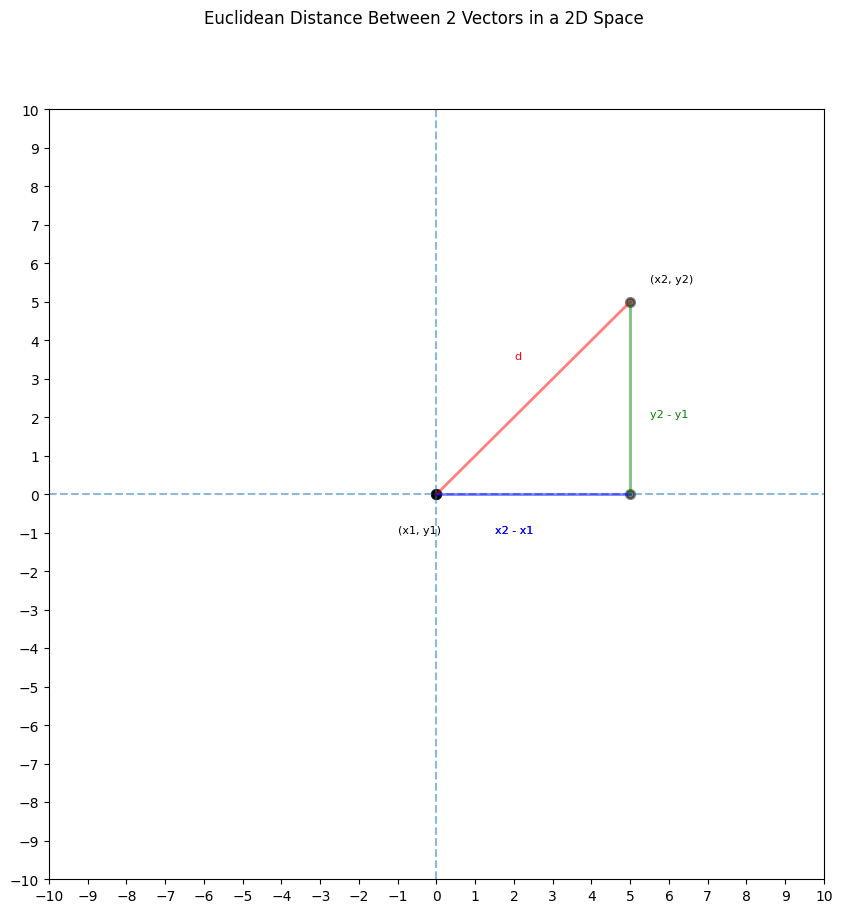

In [11]:
plot_euclidean_distance()

Vamos a calcular la distancia euclídea para 2 clientes cualquiera y posteriormente lo haremos para todas las instancias de nuestro dataset.

In [12]:
df_cl1_2 = df_clientes.T.iloc[:, :2]  # Selecciona las dos primeras columnas (Cliente1 y Cliente2) del DataFrame transpuesta (df_clientes.T).
#New daf = df principal, T... seleccion de columna
df_cl1_2["Diff"] = df_cl1_2["Cliente1"] - df_cl1_2["Cliente2"]  # Crea una nueva columna llamada "Diff" que contiene la diferencia entre los valores de "Cliente1" y "Cliente2" para cada fila.
df_cl1_2  # Muestra el DataFrame resultante (df_cl1_2) con las columnas "Cliente1", "Cliente2" y "Diff".

,Cliente1,Cliente2,Diff
1. Edad,18,30,-12
2. Peso,90,70,20
3. Altura,180,175,5
4. Nómina,2000,1500,500


In [14]:
eucl_cl1_cl2 = (((18 - 30) ** 2) + ((90 - 70) ** 2) + ((180 - 175) ** 2) + ((2000 - 1500) ** 2)) ** 0.5
print(f"La distancia euclídea entre Cliente1 y Cliente2 es {round(eucl_cl1_cl2, 1)}")

La distancia euclídea entre Cliente1 y Cliente2 es 500.6


In [15]:
df_clientes.T

,Cliente1,Cliente2,Cliente3,Cliente4,Cliente5,Cliente6
1. Edad,18,30,21,25,33,33
2. Peso,90,70,77,60,80,80
3. Altura,180,175,170,183,185,185
4. Nómina,2000,1500,3000,1800,900,3000


In [16]:
target_value = 500.6

In [18]:
distances = calculate_distances(X = df_clientes, index = index, distance_func = euclidean_distances)

target_value = distances.iloc[1, 0]

distances.style.\
applymap(lambda cell_value: format_cell_based_on_target_value(value = cell_value, target_value = target_value)).\
highlight_min(axis = 1, color = COLOR)

<ipython-input-18-54203f1fc47b>:6: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  applymap(lambda cell_value: format_cell_based_on_target_value(value = cell_value, target_value = target_value)).\


,Cliente1,Cliente2,Cliente3,Cliente4,Cliente5,Cliente6
Cliente1,nan,500.600000,1000.100000,202.400000,1100.200000,1000.200000
Cliente2,500.600000,nan,1500.100000,300.300000,600.200000,1500.100000
Cliente3,1000.100000,1500.100000,nan,1200.200000,2100.100000,19.400000
Cliente4,202.400000,300.300000,1200.200000,nan,900.300000,1200.200000
Cliente5,1100.200000,600.200000,2100.100000,900.300000,nan,2100.000000
Cliente6,1000.200000,1500.100000,19.400000,1200.200000,2100.000000,nan


<a id = "manhattan_bad"></a>
# --> Similitud basada en la distancia Manhattan (dataset sin estandarizar)
[Volver al índice](#table_of_contents)

La otra medida de distancia muy utilizada dentro del mundo del **Data Science** es la [distancia de Manhattan.](https://es.wikipedia.org/wiki/Geometr%C3%ADa_del_taxista)

Al contrario que la distancia Euclídea (donde nos desplazamos por la diagonal), en la distancia de Manhattan nos desplazamos por los catetos del triángulo (no podemos atravesar un edificio en el Eixample de Barcelona). Para ello tomamos el **valor absoluto** de la diferencia entre los elementos de cada vector.

La forma para calcular la distancia de Manhattan para N dimensiones viene dada por la siguiente fórmula:

![Distancia_Manhattan_General](https://drive.google.com/uc?export=view&id=1v6V3MmdsubMwubFpOmN_zk6LQ81mMqiR)


In [22]:
manh_cl1_cl2 = (np.abs((18 - 30)) + np.abs((90 - 70)) + np.abs((180 - 175)) + np.abs((2000 - 1500)))
# Calcula la distancia Manhattan entre Cliente1 y Cliente2.
# Para cada característica (Edad, Peso, Altura, Nómina) se calcula la diferencia absoluta entre los valores de los dos clientes y se suman todas las diferencias absolutas.

print(f"La distancia de Manhattan entre Cliente1 y Cliente2 es {round(manh_cl1_cl2, 1)}")
# Imprime un mensaje mostrando la distancia Manhattan calculada.
# "The Manhattan distance between Cliente1 and Cliente2 is":  Es el texto que se mostrará.
# {round(manh_cl1_cl2, 1)}:  Inserta el valor de la variable 'manh_cl1_cl2' (la distancia Manhattan) redondeado a 1 decimal.

La distancia de Manhattan entre Cliente1 y Cliente2 es 537


In [23]:
df_clientes.T

,Cliente1,Cliente2,Cliente3,Cliente4,Cliente5,Cliente6
1. Edad,18,30,21,25,33,33
2. Peso,90,70,77,60,80,80
3. Altura,180,175,170,183,185,185
4. Nómina,2000,1500,3000,1800,900,3000


La **distancia de Manhattan** es la suma de las diferencias absolutas entre las coordenadas de dos puntos. Es como moverse en una cuadrícula, solo en horizontal o vertical. También se le conoce como distancia del "taxista" o "city block"

In [25]:
distances = calculate_distances(X = df_clientes, index = index, distance_func = manhattan_distances)
# Calcula la matriz de distancias entre todos los clientes en el DataFrame 'df_clientes' utilizando la distancia de Manhattan.
# 'X': El DataFrame con los datos de los clientes.
# 'index': La lista de nombres de los clientes que se utilizará como índice y columnas del DataFrame resultante.
# 'distance_func': La función 'manhattan_distances' de scikit-learn, que calcula la distancia de Manhattan entre los clientes.

target_value = distances.iloc[1, 0]
# Guarda el valor de la distancia entre el Cliente2 y el Cliente1 (ubicado en la fila 1, columna 0 del DataFrame 'distances') en la variable 'target_value'.  Este valor se usará para resaltar celdas específicas en el siguiente paso.

distances.style.\
    applymap(lambda cell_value: format_cell_based_on_target_value(value = cell_value, target_value = target_value)).\
    highlight_min(axis = 1, color = COLOR)
# Aplica formato condicional al DataFrame 'distances' para resaltarlo visualmente.
# .style: Accede al objeto 'Styler' que permite aplicar formato al DataFrame.
# .applymap(...): Aplica la función 'format_cell_based_on_target_value' a cada celda del DataFrame. Esta función determina si la celda debe ser resaltada basándose en si su valor coincide con 'target_value'.
# .highlight_min(axis=1, color=COLOR): Resalta el valor mínimo en cada fila (axis=1) con el color especificado en la variable 'COLOR'.

<ipython-input-25-01ab7ea637b1>:11: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  applymap(lambda cell_value: format_cell_based_on_target_value(value = cell_value, target_value = target_value)).\


,Cliente1,Cliente2,Cliente3,Cliente4,Cliente5,Cliente6
Cliente1,nan,537.000000,1026.000000,240.000000,1130.000000,1030.000000
Cliente2,537.000000,nan,1521.000000,323.000000,623.000000,1523.000000
Cliente3,1026.000000,1521.000000,nan,1234.000000,2130.000000,30.000000
Cliente4,240.000000,323.000000,1234.000000,nan,930.000000,1230.000000
Cliente5,1130.000000,623.000000,2130.000000,930.000000,nan,2100.000000
Cliente6,1030.000000,1523.000000,30.000000,1230.000000,2100.000000,nan


<a id = "euclidea_bien"></a>
# --> Similitud basada en la distancia Euclídea (dataset estandarizado)
[Volver al índice](#table_of_contents)

Hemos podido ver en los ejemplos anteriores que al tener las 4 variables diferentes escalas, la variable de nómina se lleva todo el "protagonismo".

La distancia entre el Cliente6 y Cliente4 es de 1.230 unidades. La diferencia de nómina que tienen es de 1.200.

Claramente esto no es lo que me interesa, porque quiero tener en cuenta las 4 dimensiones descriptivas de mis clientes para determinar la similitud.

Por este motivo, antes de calcular la distancia euclídea **tengo** que estandarizar mi dataset.

Vamos a volver a calcular las distancias entre clientes, estandarizando previamente mi dataset con el StandardScaler.

**RECORDAD:** StandardScaler no cambia la forma de la distribución, los valores escalados no están acotados pero sí que el resultado final es una dataset donde la media es cero y desviación típica es 1

In [26]:
scaler = StandardScaler()
# Crea una instancia del StandardScaler.
# StandardScaler es una clase de scikit-learn que se utiliza para estandarizar los datos.
# La estandarización implica transformar los datos para que tengan una media de 0 y una desviación estándar de 1.
# Esto se logra restando la media de cada característica y dividiéndola por su desviación estándar.

In [29]:
scaled_df = scaler.fit_transform(df_clientes)
scaled_df

,1. Edad,2. Peso,3. Altura,4. Nómina
Cliente1,-1.496132,1.484749,0.060302,-0.043685
Cliente2,0.575435,-0.661876,-0.844232,-0.698963
Cliente3,-0.978240,0.089443,-1.748766,1.266871
Cliente4,-0.287718,-1.735189,0.603023,-0.305796
Cliente5,1.093327,0.411437,0.964836,-1.485297
Cliente6,1.093327,0.411437,0.964836,1.266871


In [28]:
distances = calculate_distances(
    X = scaled_df,
    index = index,
    distance_func = euclidean_distances
)

distances.style.highlight_min(axis = 1, color = COLOR)

,Cliente1,Cliente2,Cliente3,Cliente4,Cliente5,Cliente6
Cliente1,nan,3.200000,2.700000,3.500000,3.300000,3.200000
Cliente2,3.200000,nan,2.800000,2.000000,2.300000,2.900000
Cliente3,2.700000,2.800000,nan,3.400000,4.400000,3.400000
Cliente4,3.500000,2.000000,3.400000,nan,2.800000,3.000000
Cliente5,3.300000,2.300000,4.400000,2.800000,nan,2.800000
Cliente6,3.200000,2.900000,3.400000,3.000000,2.800000,nan


<a id = "manhattan_bien"></a>
# --> Similitud basada en la distancia Manhattan (dataset estandarizado)
[Volver al índice](#table_of_contents)

In [30]:
distances_scaled = calculate_distances(X = scaled_df, index = index, distance_func = manhattan_distances)
distances_scaled.style.highlight_min(axis = 1, color = COLOR)

,Cliente1,Cliente2,Cliente3,Cliente4,Cliente5,Cliente6
Cliente1,nan,5.800000,5.000000,5.200000,6.000000,5.900000
Cliente2,5.800000,nan,5.200000,3.800000,4.200000,5.400000
Cliente3,5.000000,5.200000,nan,6.400000,7.900000,5.100000
Cliente4,5.200000,3.800000,6.400000,nan,5.100000,5.500000
Cliente5,6.000000,4.200000,7.900000,5.100000,nan,2.800000
Cliente6,5.900000,5.400000,5.100000,5.500000,2.800000,nan


<a id = "transformers"></a>
# --> Otras formas de procesar los datos
[Volver al índice](#table_of_contents)

Otra forma de estandarizar nuestro dataset es utilizar el MinMaxScaler.

**RECORDAD:** **MinMaxScaler** hace el valor más pequeño de cada columna sea 0 y el máximo 1, el resto de los valores están comprendidos entre este rango.

[Más sobre el MinMaxScaler de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler)

In [31]:
scaler = MinMaxScaler()

df_clientes_max_scaled = scaler.fit_transform(df_clientes)

df_clientes_max_scaled.columns = map(lambda name: "MMS" + name, df_clientes_max_scaled.columns)
df_clientes_max_scaled = pd.concat([df_clientes_max_scaled, df_clientes], axis = 1)
df_clientes_max_scaled

df_clientes_max_scaled.style.highlight_min(axis = 0, color = COLOR).highlight_max(axis = 0, color = COLOR_MAX)

,MMS1. Edad,MMS2. Peso,MMS3. Altura,MMS4. Nómina,1. Edad,2. Peso,3. Altura,4. Nómina
Cliente1,0.000000,1.000000,0.666667,0.523810,18,90,180,2000
Cliente2,0.800000,0.333333,0.333333,0.285714,30,70,175,1500
Cliente3,0.200000,0.566667,0.000000,1.000000,21,77,170,3000
Cliente4,0.466667,0.000000,0.866667,0.428571,25,60,183,1800
Cliente5,1.000000,0.666667,1.000000,0.000000,33,80,185,900
Cliente6,1.000000,0.666667,1.000000,1.000000,33,80,185,3000


<a id = "scaler_comparison"></a>
# Comparación de los Transformers
[Volver al índice](#table_of_contents)

En esta sección vamos a ver como afectan las diferentes transformaciones a la distribución y el rango de valores de un dataset.

Recordamos que tenemos varias maneras de transformar los datos:

*   ***StandardScaler :*** No cambia la forma de la distribución y los valores escalados no están acotados pero sí que el resultado final es una dataset donde la media es cero y desviación típica es 1
*   ***MinMaxScaler :*** Los valores están acotados entre 0 - 1 y no cambia la forma
*   ***Transformación logaritmica :*** En cambio aquí, sí que cambia la forma.  Esta transformación es particularmente útil cuando los datos tienen una distribución sesgada o presentan una gran variabilidad.
*   ***Robust Scaler :*** No tiene en cuenta a los outliers ya que utiliza la mediana y el rango intercuartílico para escalar los datos basándose en estadísticas robustas.

In [32]:
X, y = load_diabetes(as_frame = True, return_X_y = True)

In [33]:
y = y.to_frame()

In [34]:
y

,target
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0
...,...
437,178.0
438,104.0
439,132.0
440,220.0


In [37]:
y_standarized = pd.DataFrame(StandardScaler().fit_transform(y))  # Estandariza 'y' (media 0, std 1).

y_min_max = pd.DataFrame(MinMaxScaler().fit_transform(y))  # Escala 'y' al rango [0, 1].

y_log = pd.DataFrame(np.log(y))  # Aplica logaritmo a 'y'.

y_robust_scaled = pd.DataFrame(RobustScaler(quantile_range = (10.0, 90.0)).fit_transform(y))  # Escala 'y' usando cuantiles (robusto a outliers).

Aprende: Analiza los datos (data) para entender sus características (ej: media, máximo, mínimo). Esto es el fit.

Transforma: Usa lo aprendido para modificar los datos. Esto es el transform.

En resumen: Aprende de los datos y luego los modifica, todo en un solo paso. Úsalo en el conjunto de entrenamiento, y luego solo transform en los datos nuevos.

<Axes: title={'center': 'RobustScaler'}, ylabel='Frequency'>

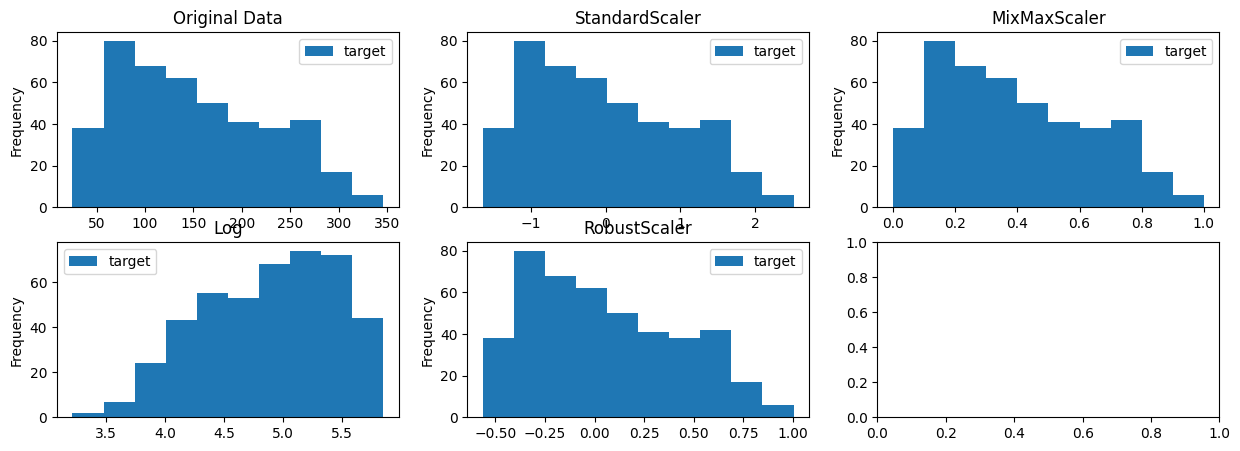

In [38]:
KIND = "hist"  # Define el tipo de gráfico a usar (histograma).

fig = plt.figure(figsize = (15, 5))  # Crea una figura (lienzo) para los gráficos con un tamaño de 15x5 pulgadas.
axes1, axes2 = fig.subplots(2, 3)  # Divide la figura en una cuadrícula de 2 filas y 3 columnas, creando 6 subgráficos (axes). 'axes1' y 'axes2' son arrays NumPy que contienen los subgráficos.
#Aquí se usa un truco para asignar los subplots a dos variables diferentes. `axes1` contendrá la primera fila de subplots y `axes2` contendrá la segunda.

y.plot(kind = KIND, ax = axes1[0], title = "Original Data")  # Dibuja un histograma de los datos originales ('y') en el primer subgráfico (fila 1, columna 1) y le pone el título "Original Data".
y_standarized.plot(kind = KIND, ax = axes1[1], title = "StandardScaler")  # Dibuja un histograma de los datos estandarizados ('y_standarized') en el segundo subgráfico (fila 1, columna 2) y le pone el título "StandardScaler".
y_min_max.plot(kind = KIND, ax = axes1[2], title = "MixMaxScaler")  # Dibuja un histograma de los datos escalados con MinMaxScaler ('y_min_max') en el tercer subgráfico (fila 1, columna 3) y le pone el título "MixMaxScaler".
y_log.plot(kind = KIND, ax = axes2[0], title = "Log")  # Dibuja un histograma de los datos transformados logarítmicamente ('y_log') en el cuarto subgráfico (fila 2, columna 1) y le pone el título "Log".
y_robust_scaled.plot(kind = KIND, ax = axes2[1], title = "RobustScaler")  # Dibuja un histograma de los datos escalados con RobustScaler ('y_robust_scaled') en el quinto subgráfico (fila 2, columna 2) y le pone el título "RobustScaler".

<a id = "knn"></a>
# Aprendizaje Basado en Instancias
[Volver al índice](#table_of_contents)

Una vez que tenemos clara la idea de similitud y distancias, una cuestión muy interesante que puede surgir es:

**¿Podemos aprovechar la distancia euclídea para resolver problemas no supervisados?**

La respuesta es sí y uno de los algoritmos más usados para estas tareas se llama el [KNN (k-Nearest Neighbors)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

Este algoritmo se llama "lazy learners" porque no existe un entrenamiento tal y como succede con otros modelos como LogisticRegression, Redes Neuronales u otros.

En vez de esto, cada vez que me solicitan una predicción utilizo el KNN para "buscar" entre todas mis instancias y entre todas las dimensiones (variables) las ejemplos más próximos (utilizando la distancia euclídea) y hago mi predicción en función de la clase mayoritaría (problemas de clasificación) o bien voy a predecir la media en caso de problemas de regresión.

![KNN](https://drive.google.com/uc?export=view&id=1_lhK7u-MwqIU-cGg_caeu17HbUQL-WUX)

In [40]:
# cargamos nuestro dataset
X_train=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Ejercicios/pd_sklearn_data.csv")

# ponemos en el índice PassengerId
X_train.set_index("PassengerId", inplace = True)

# nos quedamos con las columnas numéricas
X_train = X_train[["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex"]]

# transformamos columna Sex en booleana
X_train["Sex"] = X_train["Sex"].apply(lambda sex: 1 if sex == "female" else 0)

# creamos un indicador de que pasajero tenían nulos
X_train["Null_Age"] = X_train["Age"].isnull()

# guardamos el indicador de nulos en edad
null_age = X_train[["Null_Age"]]

# nos quedamos con las númericas
X_train.drop(columns = "Null_Age", inplace = True)

In [41]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex
PassengerId,,,,,,
1,3,22.0,1,0,7.2500,0
2,1,38.0,1,0,71.2833,1
3,3,26.0,0,0,7.9250,1
4,1,35.0,1,0,53.1000,1
5,3,35.0,0,0,8.0500,0


In [42]:
X_train.shape
minuto 2h.46min

(891, 6)

In [43]:
# instanciamos nuestro KNNImputer
knn_imputer = KNNImputer(n_neighbors = 7)

In [44]:
# Imputamos los nulos en base a 7 vecinos más cercanos
X_train_imputed = knn_imputer.fit_transform(X_train)

In [45]:
# mergemos el flag de nulos y miramos que valores hemos imputado
X_train_imputed = X_train_imputed.merge(null_age, how = "left", left_index = True, right_index = True)

# filtramos algunos nulos a modo de ejemplos
X_train_imputed[X_train_imputed["Null_Age"] == True].head(10)

,Pclass,Age,SibSp,Parch,Fare,Sex,Null_Age
PassengerId,,,,,,,
6,3.0,24.571429,0.0,0.0,8.4583,0.0,True
18,2.0,32.857143,0.0,0.0,13.0000,0.0,True
20,3.0,18.571429,0.0,0.0,7.2250,1.0,True
27,3.0,29.714286,0.0,0.0,7.2250,0.0,True
29,3.0,24.428571,0.0,0.0,7.8792,1.0,True
30,3.0,28.000000,0.0,0.0,7.8958,0.0,True
32,1.0,29.417143,1.0,0.0,146.5208,1.0,True
33,3.0,24.642857,0.0,0.0,7.7500,1.0,True
37,3.0,27.714286,0.0,0.0,7.2292,0.0,True


In [ ]:
X_train[X_train["Age"].isnull()].head(10)


El algoritmo de KNN es extremadamente potente y versátil, pero tiene 2 carencias fundamentales:
1. No es muy escalable porque para cada nueva predicción tengo que cargar toda la base de datos. Esto implica que para cada nueva predicción, tengo que calcular todas las distancias y ver cuales son estos vecinos más cercanos y en función de estos hacer el predict. Esto no succede con una Red Neuronal porque durante el entrenamiento aprendió del dataset y puede hacer el predict a partir de los paramétros inferidos en el train.


2. Un segundo problema que se presenta es que KNN necesita mucho espacio en memoria. Se tiene que cargar el dataset en memoria para hacer la búsqueda y en determinados contextos esto puede suponer un problema.

Por los dos motivos antes expuestos se recomienda usar el KNN para datasets pequeños.

<a id = "conclusión"></a>
# Conclusión
[Volver al índice](#table_of_contents)

Las principales conclusiones que podemos extraer de este notebook son:

1. La distancia Euclídea o la de Manhattan son dos formas de calcular la proximidad entre dos vectores en un espacio N dimensional. Esta distancia se puede utilizar en determinados contextos como "proxy" a similitud entre clientes. Algunos de los algoritmos que usan estas distancias son KMeans, KNN o DBScan.


2. Si nuestro dataset tiene variables que presentan diferentes escalas, es **fundamental** estandarizar antes estos valores (utilizando el StandardScaler o bien el MinMaxScaler) para que el aporte de cada atributo sea ~ el mismo.


3. Existen algoritmos que pueden hacer uso de la idea de "proximidad" para hacer muy buenas predicciones para datasets pequeños y medianos.

<a id='referencias'></a>
# Referencias y lecturas recomendables
[Volver al índice](#table_of_contents)<br>

A continuación dejamos algunos links útiles para profundizar en algunos de los conceptos que hemos visto en el notebook:

[Curse of Dimensionality](https://towardsdatascience.com/the-curse-of-dimensionality-50dc6e49aa1e)